In [1]:
import pandas as pd
from math import cos, radians, sqrt
from sklearn.neighbors import BallTree
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import warnings
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:,.2f}'.format)
np.set_printoptions(suppress = True)
np.set_printoptions(precision = 2)

In [3]:
raw = "C:\\Users\\taavi\\Desktop\\BPHIL\\Raw data\\"
clean = "C:\\Users\\taavi\\Desktop\\BPHIL\\Clean data\\"

In [4]:
parcels = pd.read_csv(clean + 'blight.csv')

In [5]:
values = pd.read_csv(clean + 'clean_values.csv')

### Make parcels time-sensitive

In [6]:
years = pd.date_range(start = values['year'].min(), end = '2026-12-31', freq = 'Y')

In [7]:
parcels = parcels.merge(pd.DataFrame({'date': years}), how = 'cross').sort_values(by = 'date').reset_index(drop = True)
parcels['date'] = parcels['date'].dt.year
parcels = parcels.rename(columns = {'date': 'year'})

### Get yearly values for each parcel

In [8]:
years = range(values['year'].min(), values['year'].max() + 1)

In [9]:
full = pd.DataFrame()

earthRadius = 6_378_137 # meters

distances = np.arange(50, 800, 50)
distances_radians = distances / earthRadius
weights = [(i + 1) / len(distances) for i, r in enumerate(distances)][::-1]

for year in tqdm(years):
    parcels_sub = parcels.loc[parcels['year'] == year].reset_index(drop = True)
    values_sub = values.loc[values['year'] == year].reset_index(drop = True)

    parcels_coords = np.radians(parcels_sub[['lat', 'lng']].to_numpy())
    values_coords = np.radians(values_sub[['lat', 'lng']].to_numpy())

    value_tree = BallTree(values_coords, metric = 'haversine')
    
    # count and sum values in each distance bin
    for d_m, d_r in zip(distances, distances_radians):
        indices_within_radius = value_tree.query_radius(parcels_coords, r = d_r)
        counts = [len(idxs) for idxs in indices_within_radius]
        parcels_sub[f'values_count_{d_m}'] = counts

        sums = [values_sub.loc[idxs, 'value'].sum() for idxs in indices_within_radius]
        parcels_sub[f'values_sum_{d_m}'] = sums

    parcels_sub = parcels_sub.fillna(0)

    for i, r in enumerate(distances[::-1]):
        if r != distances[0]:
            parcels_sub[f'values_count_{r}'] -= parcels_sub[f'values_count_{distances[::-1][i + 1]}']
            parcels_sub[f'values_sum_{r}'] -= parcels_sub[f'values_sum_{distances[::-1][i + 1]}']
    
    parcels_sub['values_count_decayed'] = (parcels_sub.iloc[:, -len(distances) * 2::2] * weights).sum(axis = 1)
    parcels_sub['values_sum_decayed'] = (parcels_sub.iloc[:, -len(distances) * 2::2] * weights).sum(axis = 1)

    parcels_sub['values_decayed'] = parcels_sub['values_sum_decayed'] / parcels_sub['values_count_decayed']

    train = parcels_sub.loc[(parcels_sub['values_decayed'].isna() == False)]
    x = train[['lat', 'lng']]
    y = train['values_decayed']

    knn = KNeighborsRegressor(n_neighbors = 5)
    parcels_sub.loc[
        (parcels_sub['values_decayed'].isna()) | (parcels_sub['values_decayed'] == 0), 'values_decayed'
        ]= knn.fit(x, y).predict(parcels_sub.loc[(parcels_sub['values_decayed'].isna()) | (parcels_sub['values_decayed'] == 0), ['lat', 'lng']])

    full = pd.concat([full, parcels_sub], axis = 0)

full = full.reset_index(drop = True)

100%|██████████| 10/10 [1:31:04<00:00, 546.45s/it]


In [10]:
parcels = full.copy()

In [64]:
parcels.to_csv(clean + 'values_decayed.csv', index = False)

In [6]:
parcels = pd.read_csv(clean + 'values_decayed.csv')

In [7]:
row_two = parcels.iloc[10_000:10_002].copy()[['parcelID', 'lat', 'lng', 'nbrhd', 'values_count_50', 'values_sum_50', 'values_count_100', 'values_sum_100']].copy()
row_one = (
    row_two
    .assign(
        values_count_100 = (row_two['values_count_100'] + row_two['values_count_50']),
        values_sum_100 = (row_two['values_sum_100'] + row_two['values_sum_50'])
    )
    .copy()
)
row_three = (
    row_two
    .assign(
        values_count_50 = row_two['values_count_50'] * (15/15),
        values_sum_50 = row_two['values_sum_50'] * (15/15),
        values_count_100 = row_two['values_count_100'] * (14/15),
        values_sum_100 = row_two['values_sum_100'] * (14/15)
    )
    .copy()
)

pd.concat([row_one, row_two, row_three], axis = 0).iloc[::2].assign(process = ['raw_count_and_sum', 'annuli_adjustment', 'distance_decay']).set_index('process')

,parcelID,lat,lng,nbrhd,values_count_50,values_sum_50,values_count_100,values_sum_100
process,,,,,,,,
raw_count_and_sum,0054P00201000000,40.42,-79.94,Greenfield,2.00,"118,001.00",4.00,"294,002.00"
annuli_adjustment,0054P00201000000,40.42,-79.94,Greenfield,2.00,"118,001.00",2.00,"176,001.00"
distance_decay,0054P00201000000,40.42,-79.94,Greenfield,2.00,"118,001.00",1.87,"164,267.60"


### Imputing nulls, 5-years past smoothing, diff and pct_change, and some column cleanup

In [65]:
parcels = parcels.sort_values(by = ['parcelID', 'year']).reset_index(drop = True)

same_parcel_prev_1 = parcels['parcelID'].eq(parcels['parcelID'].shift(1))
same_parcel_prev_2 = parcels['parcelID'].eq(parcels['parcelID'].shift(2))
same_parcel_prev_3 = parcels['parcelID'].eq(parcels['parcelID'].shift(3))
same_parcel_prev_4 = parcels['parcelID'].eq(parcels['parcelID'].shift(4))
same_parcel_prev_5 = parcels['parcelID'].eq(parcels['parcelID'].shift(5))

parcels = (
    parcels
    .assign(
        past_1 = parcels['values_decayed'].shift(1).where(same_parcel_prev_1),
        past_2 = parcels['values_decayed'].shift(2).where(same_parcel_prev_2),
        past_3 = parcels['values_decayed'].shift(3).where(same_parcel_prev_3),
        past_4 = parcels['values_decayed'].shift(4).where(same_parcel_prev_4),
        past_5 = parcels['values_decayed'].shift(5).where(same_parcel_prev_5),
    )
    .assign(
        values_smoothed = lambda x: pd.concat([x['values_decayed'], x['past_1'], x['past_2'], x['past_3'], x['past_4'], x['past_5']], axis = 1).mean(axis = 1)
    )
    .assign(
        nom_delta_1 = lambda x: x['values_smoothed'].diff(1).where(same_parcel_prev_1).shift(-1),
        nom_delta_2 = lambda x: x['values_smoothed'].diff(2).where(same_parcel_prev_2).shift(-2),
        nom_delta_3 = lambda x: x['values_smoothed'].diff(3).where(same_parcel_prev_3).shift(-3),
        nom_delta_4 = lambda x: x['values_smoothed'].diff(4).where(same_parcel_prev_4).shift(-4),
        nom_delta_5 = lambda x: x['values_smoothed'].diff(5).where(same_parcel_prev_5).shift(-5),
        pct_delta_1 = lambda x: x['values_smoothed'].pct_change(1).where(same_parcel_prev_1).shift(-1),
        pct_delta_2 = lambda x: x['values_smoothed'].pct_change(2).where(same_parcel_prev_2).shift(-2),
        pct_delta_3 = lambda x: x['values_smoothed'].pct_change(3).where(same_parcel_prev_3).shift(-3),
        pct_delta_4 = lambda x: x['values_smoothed'].pct_change(4).where(same_parcel_prev_4).shift(-4),
        pct_delta_5 = lambda x: x['values_smoothed'].pct_change(5).where(same_parcel_prev_5).shift(-5),
    )
    .assign(
        cagr_1 = lambda x: ((x['pct_delta_1'] + 1) ** (1/1)) - 1,
        cagr_2 = lambda x: ((x['pct_delta_2'] + 1) ** (1/2)) - 1,
        cagr_3 = lambda x: ((x['pct_delta_3'] + 1) ** (1/3)) - 1,
        cagr_4 = lambda x: ((x['pct_delta_4'] + 1) ** (1/4)) - 1,
        cagr_5 = lambda x: ((x['pct_delta_5'] + 1) ** (1/5)) - 1
    )
    .reset_index(drop = True)
    [['parcelID', 'lat', 'lng', 'year',
      'blight', 'blight_sqrt',
      'viols_count_decayed', 'low_count_decayed', 'high_count_decayed', 'values_decayed', 'values_smoothed',
      'viols_sqrt', 'low_sqrt', 'high_sqrt',
      'nom_delta_1', 'nom_delta_2', 'nom_delta_3', 'nom_delta_4', 'nom_delta_5',
      'pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5',
      'cagr_1', 'cagr_2', 'cagr_3', 'cagr_4', 'cagr_5']]
)

In [66]:
print('MEAN')
print(parcels[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].mean())
print('STDEV')
print(parcels[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].std())
print('\n')
print('MEDIAN')
print(parcels[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].median())
print('IQR')
print(parcels[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].quantile(0.75) -
      parcels[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].quantile(0.25))

MEAN
pct_delta_1   1.045
pct_delta_2   0.925
pct_delta_3   1.034
pct_delta_4   1.150
pct_delta_5   1.339
dtype: float64
STDEV
pct_delta_1   231.922
pct_delta_2   167.735
pct_delta_3   147.719
pct_delta_4   138.828
pct_delta_5   139.669
dtype: float64


MEDIAN
pct_delta_1   0.047
pct_delta_2   0.106
pct_delta_3   0.174
pct_delta_4   0.256
pct_delta_5   0.340
dtype: float64
IQR
pct_delta_1   0.100
pct_delta_2   0.179
pct_delta_3   0.256
pct_delta_4   0.342
pct_delta_5   0.437
dtype: float64


### Commentary:

There certainly are outliers and parts of the data look tremendously out of wack - but at scale I think it's appropriate

### Comparing values and blight

In [8]:
parcels_regression = (
    parcels
    .loc[parcels['year'] >= 2020]
    .assign(
        mean_value = lambda x: x.groupby('parcelID')['values_smoothed'].transform('mean')
    )
    .drop_duplicates(subset = 'parcelID')
)

In [68]:
model = smf.ols(formula = 'mean_value ~ viols_sqrt + low_sqrt + high_sqrt', data = parcels_regression).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             mean_value   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                 2.587e+04
Date:                Sun, 14 Sep 2025   Prob (F-statistic):               0.00
Time:                        09:48:50   Log-Likelihood:            -1.9013e+06
No. Observations:              144031   AIC:                         3.803e+06
Df Residuals:                  144027   BIC:                         3.803e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.639e+05   1013.411    161.769      0.0

In [17]:
model = smf.ols(formula = 'mean_value ~ C(blight_sqrt)', data = parcels_regression).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             mean_value   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     8757.
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        22:13:04   Log-Likelihood:            -1.9099e+06
No. Observations:              144031   AIC:                         3.820e+06
Df Residuals:                  144024   BIC:                         3.820e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.688e+05   1

In [70]:
model = smf.ols(formula = 'mean_value ~ C(blight)', data = parcels_regression).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             mean_value   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     7846.
Date:                Sun, 14 Sep 2025   Prob (F-statistic):               0.00
Time:                        09:48:51   Log-Likelihood:            -1.9120e+06
No. Observations:              144031   AIC:                         3.824e+06
Df Residuals:                  144024   BIC:                         3.824e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.051e+05    645.599    317.

In [71]:
anova_results = anova_lm(model)
print(anova_results)

                   df                    sum_sq                 mean_sq  \
C(blight)       6.000   934,560,447,028,799.750 155,760,074,504,799.969   
Residual  144,024.000 2,859,294,700,210,414.000      19,852,904,378.509   

                  F  PR(>F)  
C(blight) 7,845.707   0.000  
Residual        NaN     NaN  


In [72]:
toMerge = pd.read_csv(clean + 'clean_parcels.csv')
parcels = parcels.merge(right = toMerge[['parcelID', 'nbrhd']], on = 'parcelID', how = 'left')

In [73]:
parcels.to_csv(clean + 'blight_and_values.csv', index = False)

In [4]:
parcels = pd.read_csv(clean + 'blight_and_values.csv')

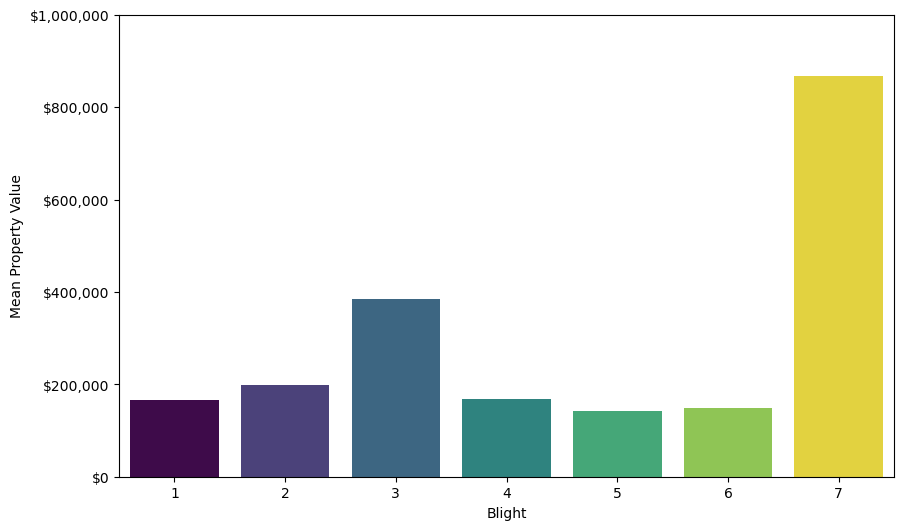

In [9]:
parcels['blight_sqrt'] = parcels['blight_sqrt'].astype(str)

plt.figure(figsize = (10, 6))

color_discrete_map = {
    '1': '#440154',
    '2': '#443983',
    '3': '#31688e',
    '4': '#21918c',
    '5': '#35b779',
    '6': '#90d743',
    '7': '#fde725'
}

sns.barplot((
    parcels
    .groupby('blight_sqrt')['values_smoothed'].mean()
    .reset_index()
    .rename(columns = {'blight_sqrt': 'Blight'})
    .melt(id_vars = 'Blight')
), x = 'Blight', y = 'value', hue = 'Blight', palette = color_discrete_map)

plt.ylabel('Mean Property Value')
locs, labels = plt.yticks()
plt.yticks(locs, [f'${int(val):,}' for val in locs])

plt.show()

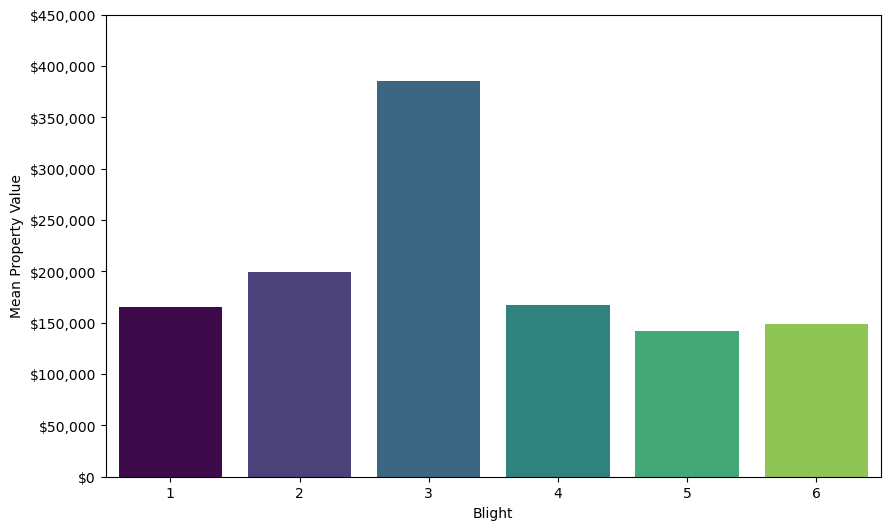

In [10]:
parcels['blight_sqrt'] = parcels['blight_sqrt'].astype(str)

plt.figure(figsize = (10, 6))

color_discrete_map = {
    '1': '#440154',
    '2': '#443983',
    '3': '#31688e',
    '4': '#21918c',
    '5': '#35b779',
    '6': '#90d743',
    '7': '#fde725'
}

sns.barplot((
    parcels.loc[parcels['blight_sqrt'] != '7']
    .groupby('blight_sqrt')['values_smoothed'].mean()
    .reset_index()
    .rename(columns = {'blight_sqrt': 'Blight'})
    .melt(id_vars = 'Blight')
), x = 'Blight', y = 'value', hue = 'Blight', palette = color_discrete_map)

plt.ylabel('Mean Property Value')
locs, labels = plt.yticks()
plt.yticks(locs, [f'${int(val):,}' for val in locs])

plt.show()

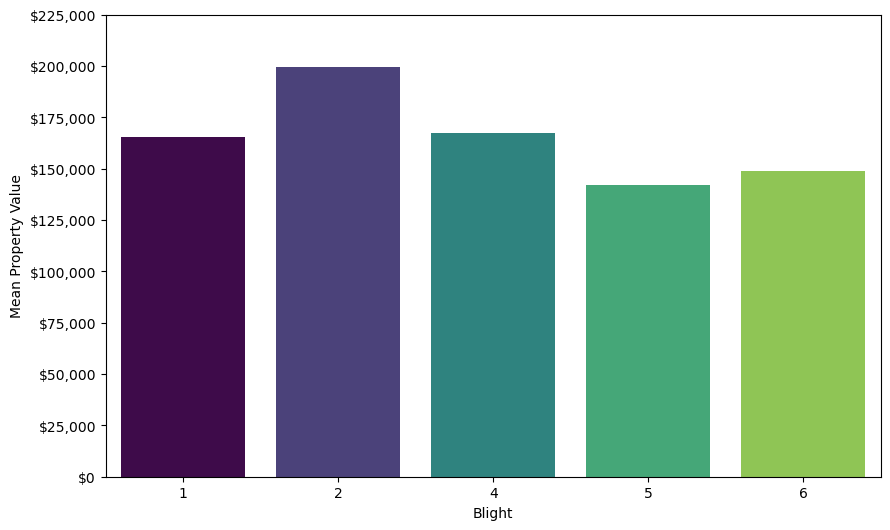

In [6]:
parcels['blight_sqrt'] = parcels['blight_sqrt'].astype(str)

plt.figure(figsize = (10, 6))

color_discrete_map = {
    '1': '#440154',
    '2': '#443983',
    '3': '#31688e',
    '4': '#21918c',
    '5': '#35b779',
    '6': '#90d743',
    '7': '#fde725'
}

sns.barplot((
    parcels.loc[~parcels['blight_sqrt'].isin(['3', '7'])]
    .groupby('blight_sqrt')['values_smoothed'].mean()
    .reset_index()
    .rename(columns = {'blight_sqrt': 'Blight'})
    .melt(id_vars = 'Blight')
), x = 'Blight', y = 'value', hue = 'Blight', palette = color_discrete_map)

plt.ylabel('Mean Property Value')
locs, labels = plt.yticks()
plt.yticks(locs, [f'${int(val):,}' for val in locs])

plt.show()

In [18]:
model = smf.ols(formula = f'mean_value ~ C(blight_sqrt)', data = parcels_regression).fit()
print(f'R-Squared: {round(model.rsquared, 3)} | F-Statistic: {round(model.fvalue, 1)} | P-Value: {round(model.f_pvalue, 3)}')
anova_results = anova_lm(model)
print(anova_results)
print('\n')

R-Squared: 0.267 | F-Statistic: 8757.4 | P-Value: 0.0
                       df                   sum_sq                mean_sq  \
C(blight_sqrt)       6.00 1,014,129,360,202,375.00 169,021,560,033,729.16   
Residual       144,024.00 2,779,725,787,036,857.50      19,300,434,559.77   

                      F  PR(>F)  
C(blight_sqrt) 8,757.40    0.00  
Residual            NaN     NaN  




In [20]:
model = smf.ols(formula = f'mean_value ~ C(blight_sqrt)', data = parcels_regression.loc[parcels_regression['blight_sqrt'] != 7]).fit()
print(f'R-Squared: {round(model.rsquared, 3)} | F-Statistic: {round(model.fvalue, 1)} | P-Value: {round(model.f_pvalue, 3)}')
anova_results = anova_lm(model)
print(anova_results)
print('\n')

R-Squared: 0.189 | F-Statistic: 6678.5 | P-Value: 0.0
                       df                   sum_sq                mean_sq  \
C(blight_sqrt)       5.00   647,096,087,748,733.00 129,419,217,549,746.59   
Residual       143,071.00 2,772,500,697,930,394.50      19,378,495,278.08   

                      F  PR(>F)  
C(blight_sqrt) 6,678.50    0.00  
Residual            NaN     NaN  




In [9]:
model = smf.ols(formula = f'mean_value ~ C(blight_sqrt)', data = parcels_regression.loc[~parcels_regression['blight_sqrt'].isin(['3', '7'])]).fit()
print(f'R-Squared: {round(model.rsquared, 3)} | F-Statistic: {round(model.fvalue, 1)} | P-Value: {round(model.f_pvalue, 3)}')
anova_results = anova_lm(model)
print(anova_results)
print('\n')

R-Squared: 0.023 | F-Statistic: 786.0 | P-Value: 0.0
                       df                   sum_sq               mean_sq  \
C(blight_sqrt)       4.00    59,697,148,559,158.27 14,924,287,139,789.57   
Residual       132,028.00 2,506,937,501,375,169.00     18,987,923,026.75   

                    F  PR(>F)  
C(blight_sqrt) 785.99    0.00  
Residual          NaN     NaN  




In [22]:
delta = []
rsq = []
fstat = []
for i in range(5):
    i += 1
    model = smf.ols(formula = f'pct_delta_{i} ~ C(blight)', data = parcels.loc[parcels['year'] == 2020]).fit()
    delta.append(f'{i} Year(s)')
    rsq.append(model.rsquared)
    fstat.append(model.fvalue)
    print(f'Percent Delta {i}')
    print(f'R-Squared: {round(model.rsquared, 3)} | F-Statistic: {round(model.fvalue, 1)} | P-Value: {round(model.f_pvalue, 3)}')
    anova_results = anova_lm(model)
    print(anova_results)
    print('\n')
results = pd.DataFrame({
    'Percent Delta': delta,
    'R-Squared': rsq,
    'F-Statistic': fstat
})

Percent Delta 1
R-Squared: 0.007 | F-Statistic: 172.0 | P-Value: 0.0
                   df    sum_sq  mean_sq       F  PR(>F)
C(blight)       6.000    62.805   10.468 172.019   0.000
Residual  144,024.000 8,764.065    0.061     NaN     NaN


Percent Delta 2
R-Squared: 0.025 | F-Statistic: 610.8 | P-Value: 0.0
                   df     sum_sq  mean_sq       F  PR(>F)
C(blight)       6.000    563.525   93.921 610.767   0.000
Residual  144,024.000 22,147.319    0.154     NaN     NaN


Percent Delta 3
R-Squared: 0.046 | F-Statistic: 1163.3 | P-Value: 0.0
                   df     sum_sq  mean_sq         F  PR(>F)
C(blight)       6.000  1,513.232  252.205 1,163.250   0.000
Residual  144,024.000 31,225.961    0.217       NaN     NaN


Percent Delta 4
R-Squared: 0.045 | F-Statistic: 1129.7 | P-Value: 0.0
                   df     sum_sq  mean_sq         F  PR(>F)
C(blight)       6.000  1,980.636  330.106 1,129.675   0.000
Residual  144,024.000 42,085.710    0.292       NaN     NaN


Percent D

In [23]:
results

,Percent Delta,R-Squared,F-Statistic
0,1 Year(s),0.007,172.019
1,2 Year(s),0.025,610.767
2,3 Year(s),0.046,"1,163.250"
3,4 Year(s),0.045,"1,129.675"
4,5 Year(s),0.065,"1,660.197"


In [24]:
for i in range(1, 6):
    tukey = pairwise_tukeyhsd(
        endog = parcels.loc[parcels['year'] == 2020][f'pct_delta_{i}'],
        groups = parcels.loc[parcels['year'] == 2020]['blight'],
        alpha = 0.01
    )
    print(f'Percent Delta {i}')
    print(f'Tukey HSD: {tukey}')
    print('\n')

Percent Delta 1
Tukey HSD: Multiple Comparison of Means - Tukey HSD, FWER=0.01 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.0099    0.0  0.0039  0.0159   True
     1      3  -0.0477    0.0  -0.058 -0.0374   True
     1      4   0.0093    0.0  0.0028  0.0158   True
     1      5   0.0333    0.0   0.025  0.0416   True
     1      6  -0.0319    0.0 -0.0419  -0.022   True
     1      7  -0.0725    0.0 -0.0902 -0.0548   True
     2      3  -0.0576    0.0 -0.0678 -0.0473   True
     2      4  -0.0006 0.9999 -0.0071  0.0058  False
     2      5   0.0234    0.0  0.0151  0.0317   True
     2      6  -0.0418    0.0 -0.0517 -0.0319   True
     2      7  -0.0824    0.0    -0.1 -0.0647   True
     3      4   0.0569    0.0  0.0464  0.0675   True
     3      5    0.081    0.0  0.0692  0.0928   True
     3      6   0.0158 0.0005  0.0028  0.0287   True
     3      7  -0.0248 0.0002 -0.0443 -0.0053   True
     4      5    0.

In [25]:
parcels.loc[parcels['year'] == 2020].groupby('blight')[[f'pct_delta_{i + 1}' for i in range(5)]].median().reset_index().rename(columns = {'blight': 'Blight'})

,Blight,pct_delta_1,pct_delta_2,pct_delta_3,pct_delta_4,pct_delta_5
0,1,0.086,0.169,0.191,0.253,0.319
1,2,0.098,0.201,0.259,0.303,0.354
2,3,0.057,0.077,0.060,0.101,0.121
3,4,0.110,0.198,0.264,0.339,0.402
4,5,0.134,0.247,0.338,0.446,0.604
5,6,0.084,0.187,0.539,0.621,0.676
6,7,0.040,0.081,0.181,0.211,0.255


In [100]:
parcels.loc[parcels['year'] == 2020].groupby('blight')[[f'pct_delta_{i + 1}' for i in range(5)]].mean().reset_index().rename(columns = {'blight': 'Blight'})

,Blight,pct_delta_1,pct_delta_2,pct_delta_3,pct_delta_4,pct_delta_5
0,1,0.074,0.182,0.232,0.305,0.371
1,2,0.067,0.184,0.251,0.311,0.362
2,3,-0.018,0.002,0.094,0.126,0.116
3,4,0.079,0.208,0.287,0.375,0.467
4,5,0.086,0.347,0.614,0.731,0.846
5,6,0.014,0.058,0.273,0.283,0.314
6,7,-0.006,-0.113,-0.091,-0.128,-0.121
